In [1]:
import data
from lwhf.ml_logic.data_BQ import get_data
import pandas as pd
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

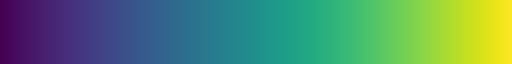

In [42]:
cmap = plt.get_cmap('viridis')
cmap

In [101]:
assets_df = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

assets = assets_df['Symbol'].to_list()
assets.sort()

In [112]:
'''
TRAIN DATA
'''

start = '2010-01-01'
end = '2020-06-10'

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

#DISPLAYS ALL DATAFRAMES WITH PERCENTAGE NOW ON
#pd.options.display.float_format = '{:.4%}'.format

#RETURNS ON ONE WEEK (5)
Y = data[assets].pct_change(5)[5:]
Y = Y.dropna(axis=1)

[***********           22%%                      ]  110 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2010-01-01 -> 2020-06-10)


[*********************100%%**********************]  503 of 503 completed

9 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2010-01-01 -> 2020-06-10)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['CEG', 'SOLV', 'KVUE', 'GEHC', 'ABNB', 'GEV', 'VLTO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1591761600")


In [116]:
print(Y.shape)

(2621, 433)


# 2. Estimating Mean Variance Portfolios
https://nbviewer.org/github/dcajasn/Riskfolio-Lib/blob/master/examples/Tutorial%201%20-%20Classic%20Mean%20Risk%20Optimization.ipynb

2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [9]:
class Portfolio_Optimisation:

    def __init__(self, Y, method_mu='hist',
                method_cov='hist',
                model='Classic',
                rm = 'MV',
                obj = 'Sharpe',
                hist = True,
                rf = 0,
                l = 0):

        self.Y = Y
        self.method_mu = method_mu
        self.method_cov = method_cov
        self.model = model
        self.rm = rm
        self.obj = obj
        self.hist = hist
        self.rf = rf
        self.l = l


    def building_portfolio(self):

        '''
        Calculates current optimal portfolio for the future

        INPUT
        * Y: datafame containing returns as columns and dates as index
        * Methods to estimate input parameters:
            method_mu='hist' # Method to estimate expected returns based on historical data.
            method_cov='hist' # Method to estimate covariance matrix based on historical data.
            model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
            rm = 'MV' # Risk measure used, this time will be variance
            obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
            hist = True # Use historical scenarios for risk measures that depend on scenarios
            rf = 0 # Risk free rate
            l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        OUTPUT
        * port: object for the portfolio
        * w: weight of the optimised portfolio
        '''
        # Building the portfolio object
        port = rp.Portfolio(returns=self.Y)

        #find estimates for returns and covariance or # input manually the custom parameters

        port.assets_stats(method_mu=self.method_mu, method_cov=self.method_cov, d=0.94)

        #find weights that maximizes Sharpe ratio (rm = 'MV'; Mean-Variance)
        w = port.optimization(model=self.model, rm=self.rm, obj=self.obj, rf=self.rf, l=self.l, hist=self.hist)

        self.port = port
        self.w = w

        return port, w

    def pie_weights(self):
        ax = rp.plot_pie( w= self.w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                        height=6, width=10, ax=None)

    def EfficientFrontier(self, n_points = 50):
        points = 50 # Number of points of the frontier
        frontier = self.port.efficient_frontier(model=self.model, rm=self.rm, points=n_points, rf=self.rf, hist=self.hist)
        self.frontier = frontier
        return frontier

    def plot_EF(self):
        label = 'Max Risk Adjusted Return Portfolio' # Title of point
        self.mu = self.port.mu # Expected returns
        self.cov = self.port.cov # Covariance matrix
        self.returns = self.port.returns # Returns of the assets
        ax = rp.plot_frontier(w_frontier=self.frontier, mu=self.mu, cov=self.cov, returns=self.returns, rm=self.rm,
                        rf=self.rf, alpha=0.05, cmap='viridis', w=self.w, label=label,
                        marker='*', s=16, c='r', height=6, width=10, ax=None)
    def plot_EF_assetStructure(self):
        ax = rp.plot_frontier_area(w_frontier=self.frontier, cmap="tab20", height=6, width=10, ax=None)


In [10]:
my_por = Portfolio_Optimisation(Y, method_mu='hist',
                       method_cov='hist',
                       model='Classic',
                       rm = 'MV',
                       obj = 'Sharpe',
                       hist = True,
                       rf = 0,
                       l = 0)

port, w = my_por.building_portfolio()

2.2 Plotting portfolio composition

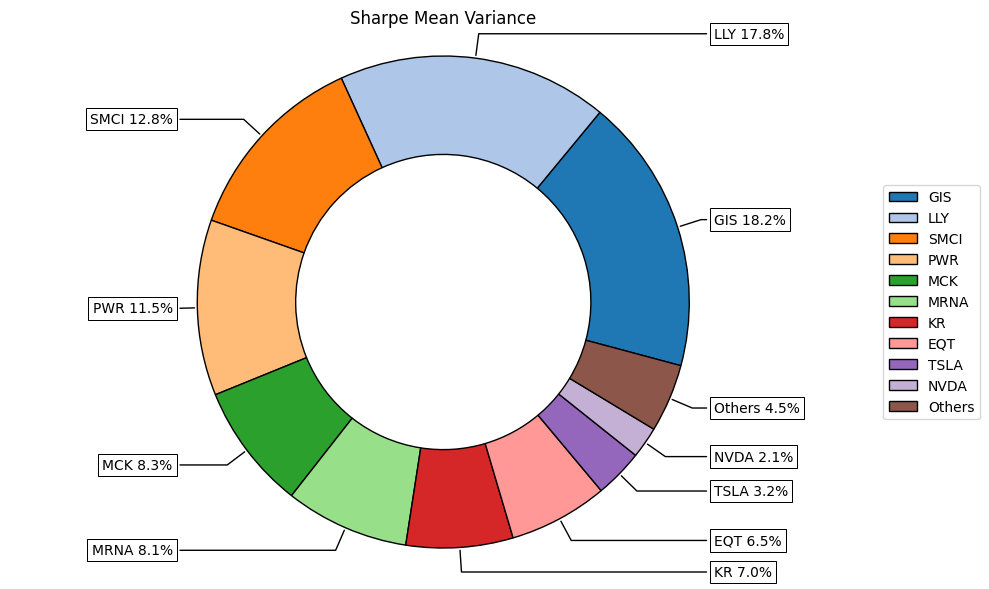

In [11]:
# Plotting the composition of the portfolio
my_por.pie_weights()

2.3 Calculate efficient frontier

In [67]:
frontier = my_por.EfficientFrontier(n_points = 50)

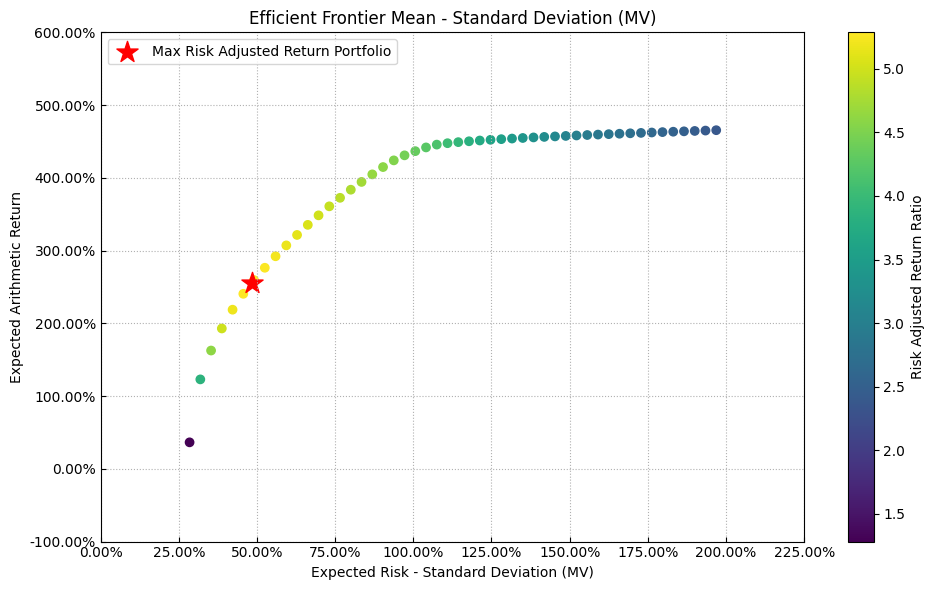

In [68]:
# Plotting the efficient frontier
my_por.plot_EF()

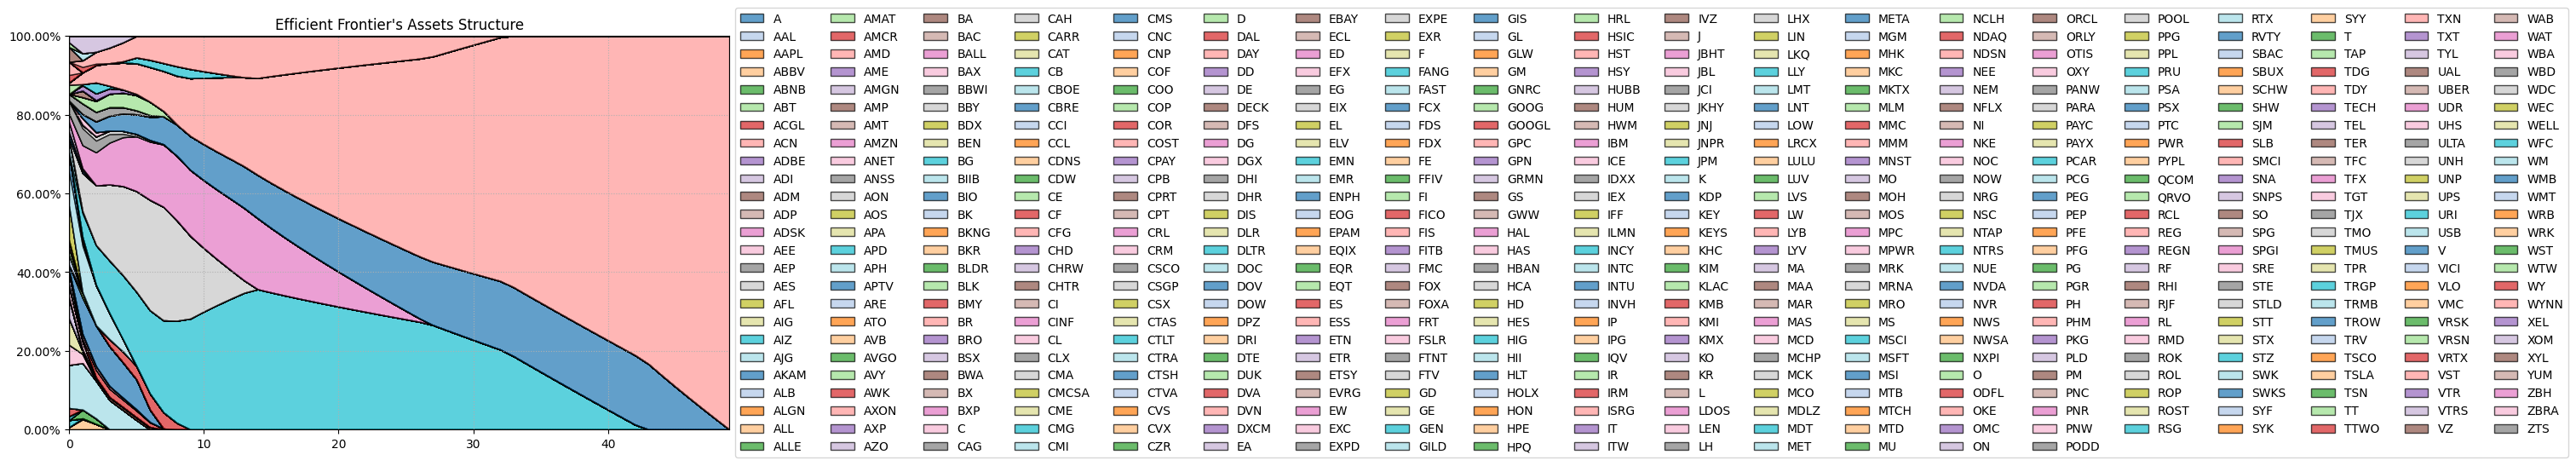

In [17]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [ ]:
my_por.plot_EF_assetStructure()

### Backtesting MV

In [103]:
assets_df = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

'''
TRAIN DATA
'''

# Date range
start = '2018-01-01'
end = '2024-12-31'

# Tickers of assets
assets = assets_df['Symbol'].to_list()
for x in ['KVUE', 'VLTO', 'GEV', 'CEG', 'GEHC', 'SOLV', 'BRK.B', 'BF.B', 'ABNB', 'CARR', 'OTIS', 'UBER','CTVA', 'DAY', 'DOW', 'FOX', 'FOXA', 'MRNA']:
    assets.remove(x)
assets.sort()


# Downloading data
prices = yf.download(assets, start=start, end=end)
prices = prices.dropna()
display(prices.head())

[*********************100%%**********************]  485 of 485 completed


Price       Adj Close                                                         \
Ticker              A        AAL       AAPL       ABBV        ABT       ACGL   
Date                                                                           
2018-01-02  65.523422  51.647556  41.310070  79.061188  54.864079  29.433332   
2018-01-03  67.190582  51.014027  41.302879  80.298409  54.985394  29.459999   
2018-01-04  66.686562  51.335667  41.494736  79.840477  54.892067  29.570000   
2018-01-05  67.752769  51.316177  41.967163  81.230316  55.050713  29.453333   
2018-01-08  67.898155  50.809345  41.811283  79.928841  54.892067  29.456667   

Price                                                     ...  Volume  \
Ticker             ACN        ADBE        ADI        ADM  ...     WTW   
Date                                                      ...           
2018-01-02  144.704498  177.699997  84.230858  35.328026  ...  817700   
2018-01-03  145.372330  181.039993  85.275818  35.054844  ...  771200   
2018-01-04  147.093643  183.220001  85.182518  35.645275  ...  800900   
2018-01-05  148.307053  185.339996  85.527702  35.407337  ...  646700   
2018-01-08  149.492203  185.039993  85.676994  35.328026  ...  632700   

Price                                                                      \
Ticker           WY     WYNN      XEL       XOM     XYL      YUM      ZBH   
Date                                                                        
2018-01-02  3144000  2581200  2443400  11469300  877800  1747800  1818259   
2018-01-03  2922800  3530900  4114900  13957700  778800  2554900  1368664   
2018-01-04  2727800  2708800  2807000  10863000  796500  1971200  1105396   
2018-01-05  2924800  2186600  3728000  11047600  666800  1927100  1095302   
2018-01-08  2760800  1803800  3837600  10927100  554700  1599400  1286985   

Price                        
Ticker        ZBRA      ZTS  
Date                         
2018-01-02  310600  2135600  
2018-01-03  253000  2328200  
2018-01-04  435200  2534000  
2018-01-05  301800  2166100  
2018-01-08  218600  3631400  

[5 rows x 2910 columns]

In [104]:
############################################################
# Create objects that contain the prices of assets
############################################################

import backtrader as bt
# Creating Assets bt.feeds
assets_prices = []
for i in assets:
    prices_ = prices.drop(columns='Adj Close').loc[:, (slice(None), i)].dropna()
    prices_.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    assets_prices.append(bt.feeds.PandasData(dataname=prices_, plot=False))
benchmark = bt.feeds.PandasData(dataname=prices_, plot=False)

#for eahc stock
display(prices_.head())

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,71.769997,72.589996,71.470001,72.540001,2135600
2018-01-03,72.099998,72.180000,71.339996,71.769997,2328200
2018-01-04,72.529999,72.910004,72.260002,72.750000,2534000
2018-01-05,73.360001,73.919998,72.570000,72.830002,2166100
2018-01-08,74.239998,74.419998,73.160004,73.430000,3631400


In [106]:
import backtrader as bt
def backtest(datas, strategy, start, end, plot=False, **kwargs):
    cerebro = bt.Cerebro()

    # Here we add transaction costs and other broker costs
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.005) # Commission 0.5%
    cerebro.broker.set_slippage_perc(0.005, # Slippage 0.5%
                                     slip_open=True,
                                     slip_limit=True,
                                     slip_match=True,
                                     slip_out=False)
    for data in datas:
        cerebro.adddata(data)

    # Here we add the indicators that we are going to store
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)

    #Call the strategies’ next method to let the strategy evaluate the new data
    cerebro.addstrategy(strategy, **kwargs)

    #OBSERVER
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)
    #execute backtesting
    results = cerebro.run(stdstats=False)
    if plot:
        cerebro.plot(iplot=False, start=start, end=end)
    return (results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'])

In [110]:
############################################################
# Calculate assets returns
############################################################

pd.options.display.float_format = '{:.4%}'.format

data = prices.loc[:, ('Adj Close', slice(None))]
data.columns = assets
data = data.dropna()
returns = data.pct_change(5).dropna()
display(returns.head())

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-09,6.1686%,-1.7173%,1.2017%,1.8596%,0.2211%,-1.2118%,3.6531%,5.0647%,1.5064%,0.3243%,...,3.2927%,-0.1133%,-0.5478%,-2.5518%,2.0464%,2.1008%,1.4216%,0.1048%,9.9412%,4.6537%
2018-01-10,2.1206%,2.7512%,1.1961%,-0.2601%,-0.1527%,-1.8443%,2.8146%,3.3529%,-1.4114%,0.3268%,...,2.5845%,-2.1904%,-0.3200%,-2.8638%,-0.7151%,0.1451%,1.2511%,-1.9132%,8.5185%,2.5104%
2018-01-11,2.9070%,7.1198%,1.3003%,0.6058%,0.7003%,0.1804%,1.7457%,3.1110%,-0.1205%,0.2719%,...,2.3139%,-0.9343%,-0.5508%,-3.3956%,0.1267%,0.8795%,0.1579%,-1.9641%,12.3401%,2.8402%
2018-01-12,2.6180%,11.0541%,1.1943%,-0.0497%,0.2227%,2.6369%,1.5475%,5.2390%,0.3818%,0.7964%,...,2.1218%,-0.0284%,0.6383%,-3.5050%,0.8876%,1.7767%,0.9416%,-3.0799%,12.4247%,2.7672%
2018-01-16,1.6845%,11.2219%,1.0554%,3.7543%,-0.1709%,3.4061%,-0.6103%,4.0100%,1.3830%,1.7211%,...,0.7727%,-2.0845%,3.9618%,-3.9245%,-0.1951%,1.5256%,-0.0602%,-3.5969%,11.5249%,1.7511%


In [166]:
############################################################
# Selecting Dates for Rebalancing
############################################################

# Selecting last day of month of available data
index = returns.groupby([returns.index.year, returns.index.month]).tail(1).index
index_2 = returns.index

#We want to rebalance every month
index = [x for x in index if (float(x.month) - float(index[0].month) + float(1)) % 1.0 == 0 ]

#Start trading after 4 years
index_ = [index_2.get_loc(x) for x in index if index_2.get_loc(x) > 1000]

In [167]:
import riskfolio as rp
#we will rebalance our portfolio here:
#returns.iloc[index_,:].index
index_ = index_[-2:]

In [ ]:
############################################################
# Building Constraints
############################################################

# asset_classes = {'Assets': ['JCI','TGT','CMCSA','CPB','MO','APA','MMC','JPM',
#                             'ZION','PSA','BAX','BMY','LUV','PCAR','TXT','TMO',
#                             'DE','MSFT','HPQ','SEE','VZ','CNP','NI','T','BA'],
#                  'Industry': ['Consumer Discretionary','Consumer Discretionary',
#                               'Consumer Discretionary', 'Consumer Staples',
#                               'Consumer Staples','Energy','Financials',
#                               'Financials','Financials','Financials',
#                               'Health Care','Health Care','Industrials','Industrials',
#                               'Industrials','Health care','Industrials',
#                               'Information Technology','Information Technology',
#                               'Materials','Telecommunications Services','Utilities',
#                               'Utilities','Telecommunications Services','Financials']}

# asset_classes = pd.DataFrame(asset_classes)
# asset_classes = asset_classes.sort_values(by=['Assets'])

# constraints = {'Disabled': [False, False, False],
#                'Type': ['All Assets', 'All Classes', 'All Classes'],
#                'Set': ['', 'Industry', 'Industry'],
#                'Position': ['', '', ''],
#                'Sign': ['<=', '<=', '>='],
#                'Weight': [0.10, 0.20, 0.03],
#                'Type Relative': ['', '', ''],
#                'Relative Set': ['', '', ''],
#                'Relative': ['', '', ''],
#                'Factor': ['', '', '']}

# constraints = pd.DataFrame(constraints)

# display(constraints)
#A, B = rp.assets_constraints(constraints, asset_classes)

In [168]:
############################################################
# Building a loop that estimate optimal portfolios on
# rebalancing dates
############################################################

models = {}

# rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
#        'CVaR', 'WR', 'MDD', 'ADD', 'CDaR']

rms = ['MV'] #, 'CVaR', 'WR', 'CDaR']

for j in rms:

    weights = pd.DataFrame([])

    #for each time we want oto backtest index_
    for i in index_:
        Y = returns.iloc[i-1000:i,:] #taking last 4 years (250 trading days per year)

        # Building the portfolio object
        port = rp.Portfolio(returns=Y)

        # Add portfolio constraints
        #port.ainequality = A
        #port.binequality = B

        # Calculating optimum portfolio

        # Select method and estimate input parameters:

        method_mu='hist' # Method to estimate expected returns based on historical data.
        method_cov='hist' # Method to estimate covariance matrix based on historical data.

        port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

        # Estimate optimal portfolio:

        #port.solvers = ['MOSEK']
        port.alpha = 0.05
        model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
        rm = j # Risk measure used, this time will be variance
        obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
        hist = True # Use historical scenarios for risk measures that depend on scenarios
        rf = 0 # Risk free rate
        l = 0 # Risk aversion factor, only useful when obj is 'Utility'

        w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

        if w is None:
            w = weights.tail(1).T
        weights = pd.concat([weights, w.T], axis = 0)

    models[j] = weights.copy()
    models[j].index = index_

In [169]:
############################################################
# Building the Buy and Hold strategy
############################################################

class BuyAndHold(bt.Strategy):
    def __init__(self):
        self.counter = 0
    def next(self):
        if self.counter >= 1004:
            if self.getposition(self.data).size == 0:
                self.order_target_percent(self.data, target=0.99)
        self.counter += 1

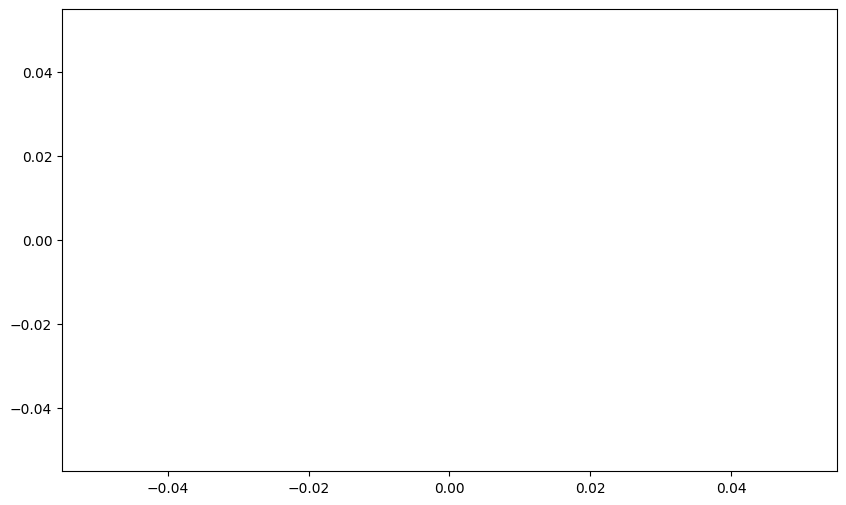

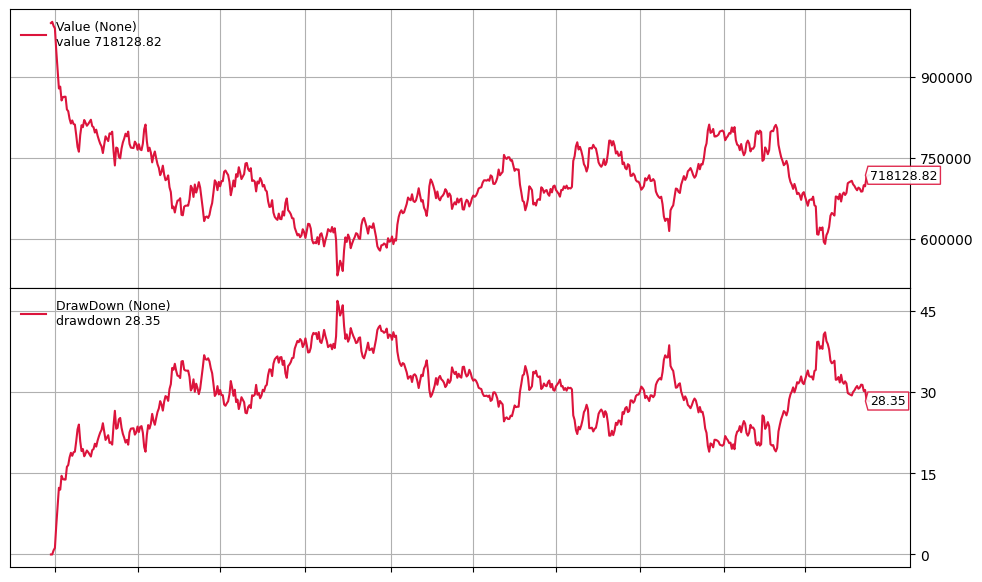

In [171]:
############################################################
# Run the backtest for the selected period
############################################################
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.plot() # We need to do this to avoid errors in inline plot

start = 1004 #since started backtesting from
end = prices.shape[0] - 1

dd, cagr, sharpe = backtest([benchmark],
                            BuyAndHold,
                            start=start,
                            end=end,
                            plot=True)


In [174]:
cagr

0.25879727391419804

In [126]:
############################################################
# Building the Asset Allocation Class
############################################################

class AssetAllocation(bt.Strategy):
    def __init__(self):
        j = 0
        for i in assets:
            setattr(self, i, self.datas[j])
            j += 1
        self.counter = 0
    def next(self):
        if self.counter in weights.index.tolist():
            for i in assets:
                w = weights.loc[self.counter, i]
                self.order_target_percent(getattr(self, i), target=w)
        self.counter += 1

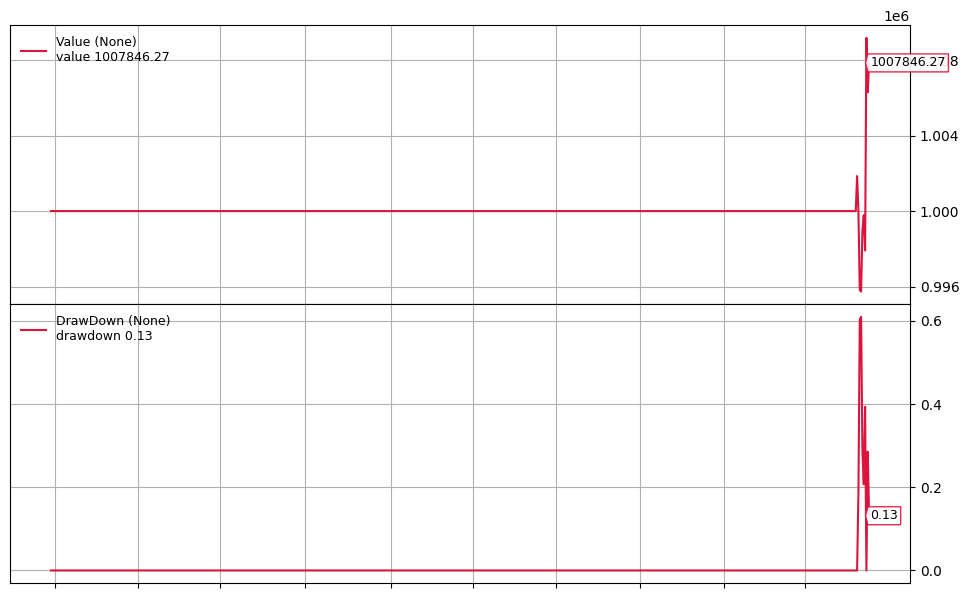

In [172]:
############################################################
# Backtesting Mean Variance Strategy
############################################################

assets = returns.columns.tolist()
weights = models['MV']

dd, cagr, sharpe = backtest(assets_prices,
                            AssetAllocation,
                            start=start,
                            end=end,
                            plot=True)

In [128]:
############################################################
# Show Mean Variance Strategy Stats
############################################################

print(f"Max Drawdown: {dd:.2f}%")
print(f"CAGR: {cagr:.2f}%")
print(f"Sharpe: {sharpe:.3f}")

Max Drawdown: 19.22%
CAGR: 9.94%
Sharpe: 0.550


array([<Axes: ylabel='1614'>], dtype=object)

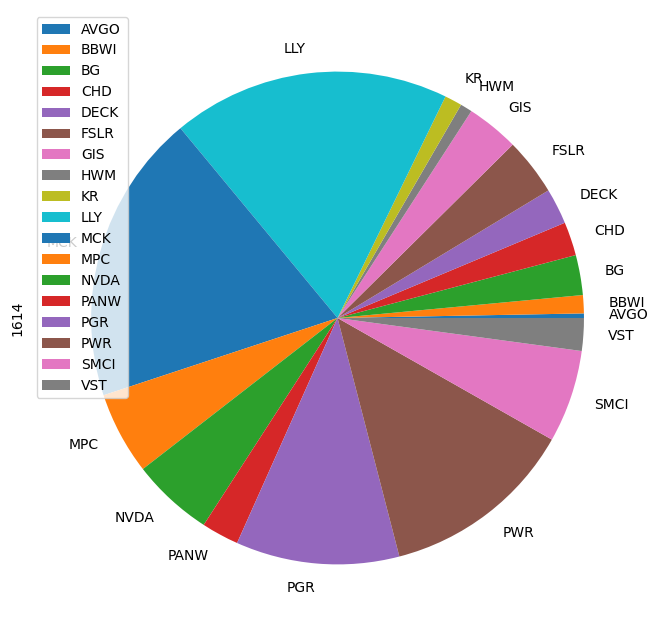

In [151]:
############################################################
#Weights of Last MV portfolio
############################################################

w = pd.DataFrame(models['MV'].iloc[-1,:])
w = w[pd.DataFrame(w > 1e-10).values]
w.plot.pie(subplots=True, figsize=(8, 8))

In [160]:
w

,1614
AVGO,0.2969%
BBWI,1.1904%
BG,2.6234%
CHD,2.2056%
DECK,2.3437%
FSLR,3.7576%
GIS,3.4448%
HWM,0.7829%
KR,1.1373%
LLY,18.2233%


In [161]:
prices

Price        Adj Close                                                 \
Ticker               A        AAL        AAPL        ABBV         ABT   
Date                                                                    
2018-01-02  6552.3422% 5164.7556%  4131.0070%  7906.1188%  5486.4079%   
2018-01-03  6719.0582% 5101.4027%  4130.2879%  8029.8409%  5498.5394%   
2018-01-04  6668.6562% 5133.5667%  4149.4736%  7984.0477%  5489.2067%   
2018-01-05  6775.2769% 5131.6177%  4196.7163%  8123.0316%  5505.0713%   
2018-01-08  6789.8155% 5080.9345%  4181.1283%  7992.8841%  5489.2067%   
...                ...        ...         ...         ...         ...   
2024-06-04 13085.0006% 1150.0000% 19435.0006% 16213.9999% 10343.0000%   
2024-06-05 13355.9998% 1162.0000% 19586.9995% 16544.0002% 10323.0003%   
2024-06-06 13282.0007% 1143.0000% 19447.9996% 16857.0007% 10426.9997%   
2024-06-07 13297.9996% 1150.0000% 19688.9999% 16941.9998% 10758.0002%   
2024-06-10 13302.9999% 1149.0000% 19311.9995% 17046.0007% 10748.9998%   

Price                                                                  ...  \
Ticker            ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                   ...   
2018-01-02  2943.3332% 14470.4498% 17769.9997%  8423.0858% 3532.8026%  ...   
2018-01-03  2945.9999% 14537.2330% 18103.9993%  8527.5818% 3505.4844%  ...   
2018-01-04  2957.0000% 14709.3643% 18322.0001%  8518.2518% 3564.5275%  ...   
2018-01-05  2945.3333% 14830.7053% 18533.9996%  8552.7702% 3540.7337%  ...   
2018-01-08  2945.6667% 14949.2203% 18503.9993%  8567.6994% 3532.8026%  ...   
...                ...         ...         ...         ...        ...  ...   
2024-06-04 10086.0001% 28805.9998% 44836.9995% 23063.0005% 6182.0000%  ...   
2024-06-05  9968.0000% 29101.9989% 45579.9988% 23567.9993% 6107.0000%  ...   
2024-06-06 10008.0002% 29173.9990% 45813.0005% 23741.0004% 6116.9998%  ...   
2024-06-07 10057.0000% 28839.9994% 46542.9993% 23477.0004% 6127.0000%  ...   
2024-06-10 10058.0002% 29042.9993% 45994.0002% 23536.9995% 6195.0001%  ...   

Price       Volume                                                         \
Ticker         WTW       WY     WYNN      XEL       XOM      XYL      YUM   
Date                                                                        
2018-01-02  817700  3144000  2581200  2443400  11469300   877800  1747800   
2018-01-03  771200  2922800  3530900  4114900  13957700   778800  2554900   
2018-01-04  800900  2727800  2708800  2807000  10863000   796500  1971200   
2018-01-05  646700  2924800  2186600  3728000  11047600   666800  1927100   
2018-01-08  632700  2760800  1803800  3837600  10927100   554700  1599400   
...            ...      ...      ...      ...       ...      ...      ...   
2024-06-04  259000  2485500  1522900  3460000  19412200  1078400  2125200   
2024-06-05  296100  2472400  1335000  2474900  14863500   973500  1944000   
2024-06-06  255600  4555100  1194600  2395000  13154100  1190300  1528900   
2024-06-07  319100  3397900  1416200  3824500  13289200   873900  1467100   
2024-06-10  261500  4424000  1395500  4067900  15245200  1304100  1717000   

Price                                 
Ticker          ZBH    ZBRA      ZTS  
Date                                  
2018-01-02  1818259  310600  2135600  
2018-01-03  1368664  253000  2328200  
2018-01-04  1105396  435200  2534000  
2018-01-05  1095302  301800  2166100  
2018-01-08  1286985  218600  3631400  
...             ...     ...      ...  
2024-06-04  1186700  219500  1304400  
2024-06-05   918100  248000  1870800  
2024-06-06   902300  162800  2722200  
2024-06-07  1070300  187300  1819400  
2024-06-10  1214500  227800  2506900  

[1620 rows x 2910 columns]

In [162]:
returns

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-09,6.1686%,-1.7173%,1.2017%,1.8596%,0.2211%,-1.2118%,3.6531%,5.0647%,1.5064%,0.3243%,...,3.2927%,-0.1133%,-0.5478%,-2.5518%,2.0464%,2.1008%,1.4216%,0.1048%,9.9412%,4.6537%
2018-01-10,2.1206%,2.7512%,1.1961%,-0.2601%,-0.1527%,-1.8443%,2.8146%,3.3529%,-1.4114%,0.3268%,...,2.5845%,-2.1904%,-0.3200%,-2.8638%,-0.7151%,0.1451%,1.2511%,-1.9132%,8.5185%,2.5104%
2018-01-11,2.9070%,7.1198%,1.3003%,0.6058%,0.7003%,0.1804%,1.7457%,3.1110%,-0.1205%,0.2719%,...,2.3139%,-0.9343%,-0.5508%,-3.3956%,0.1267%,0.8795%,0.1579%,-1.9641%,12.3401%,2.8402%
2018-01-12,2.6180%,11.0541%,1.1943%,-0.0497%,0.2227%,2.6369%,1.5475%,5.2390%,0.3818%,0.7964%,...,2.1218%,-0.0284%,0.6383%,-3.5050%,0.8876%,1.7767%,0.9416%,-3.0799%,12.4247%,2.7672%
2018-01-16,1.6845%,11.2219%,1.0554%,3.7543%,-0.1709%,3.4061%,-0.6103%,4.0100%,1.3830%,1.7211%,...,0.7727%,-2.0845%,3.9618%,-3.9245%,-0.1951%,1.5256%,-0.0602%,-3.5969%,11.5249%,1.7511%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-04,-11.7131%,-14.4345%,2.2949%,4.3775%,1.4517%,-1.3594%,-3.2479%,-6.2831%,-1.2037%,1.5273%,...,1.8154%,-0.9745%,-0.6310%,4.2613%,-1.9067%,-2.3226%,4.1808%,-2.4843%,-7.1941%,0.3386%
2024-06-05,-8.1936%,0.0000%,2.9324%,6.8803%,2.4819%,-1.8415%,-0.9361%,-4.5645%,3.3005%,1.7325%,...,1.5740%,0.3065%,0.8970%,3.4897%,-0.4488%,1.2468%,4.3514%,-2.1713%,-2.9754%,2.9391%
2024-06-06,1.0653%,-0.0874%,1.6676%,7.8434%,2.4867%,-1.3115%,2.4368%,2.7497%,3.2217%,1.7127%,...,1.2572%,0.1346%,-0.0648%,0.9205%,-0.0175%,-1.8149%,4.4423%,-0.9350%,-2.8836%,4.3319%
